In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5, 
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})

#seaborn.set(style="ticks", context="talk")
plt.style.use("dark_background")
seaborn.set_style({'grid.color': '.4'})

#seaborn.set_style("darkgrid")


from sklearn.metrics import mean_squared_error

# a) Data preperation.
From Mehta's notebook 4.

## Creation of 1D

In [2]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states,L)

In [63]:
print(states)
print(states.shape)

[[ 1  1 -1 ... -1 -1 -1]
 [-1 -1  1 ... -1 -1 -1]
 [-1  1  1 ... -1 -1  1]
 ...
 [-1  1 -1 ... -1 -1  1]
 [ 1 -1 -1 ...  1 -1  1]
 [-1 -1  1 ... -1  1 -1]]
(10000, 40)


In [64]:
print(energies)
print(energies.shape)

[  4. -12.   4. ...   0.  -8.   8.]
(10000,)


In [3]:
# All possible spin combinations
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

In [66]:
print(len(Data))
print(Data[0].shape, Data[1].shape)

2
(10000, 1600) (10000,)


## Train

In [4]:
# define number of samples
n_samples=400
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

In [27]:
print(X_train.shape)

(400, 1600)


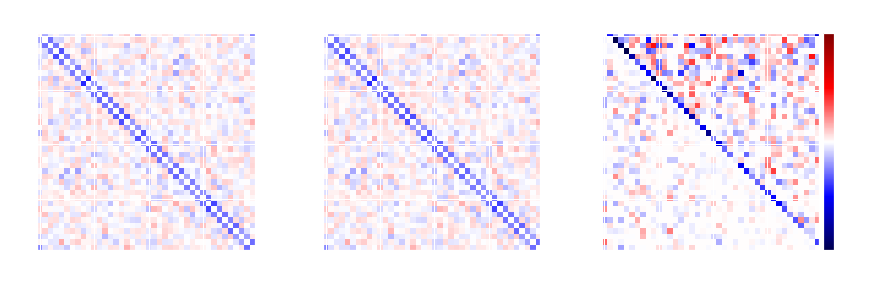

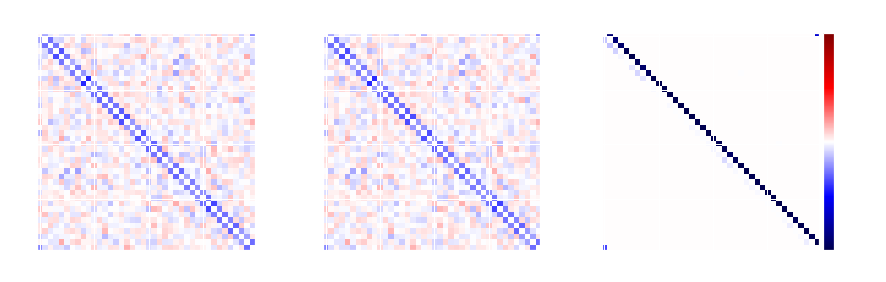

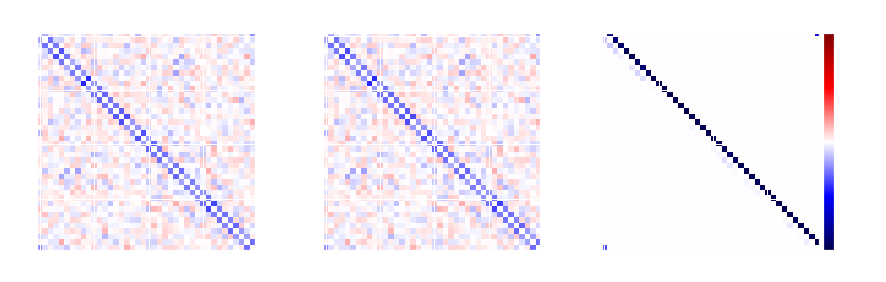

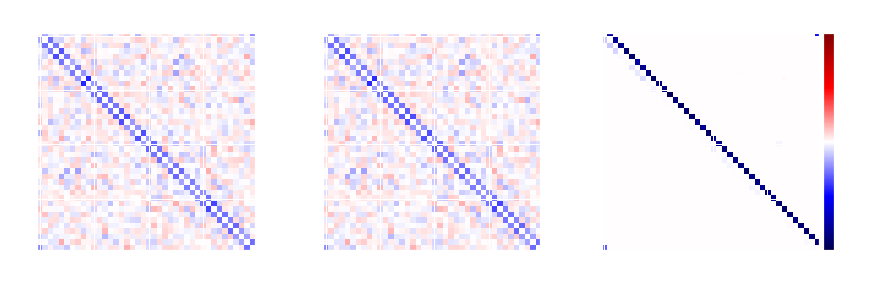

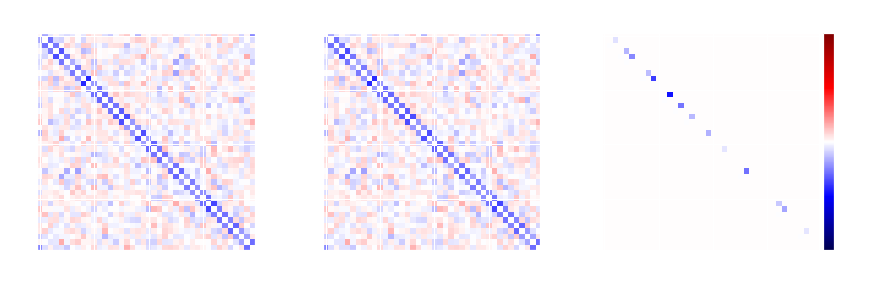

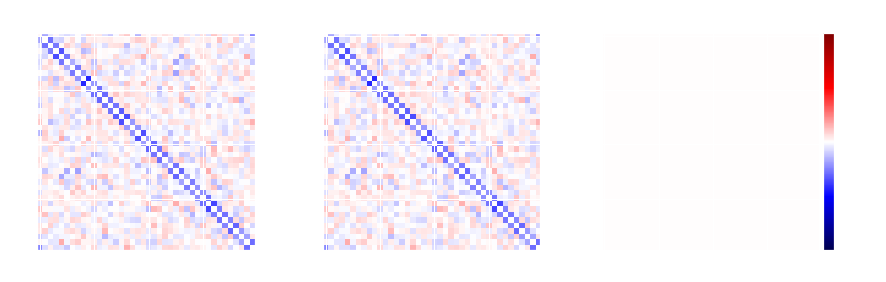

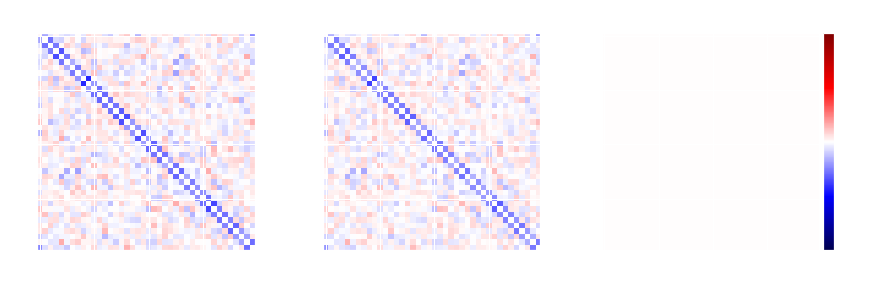

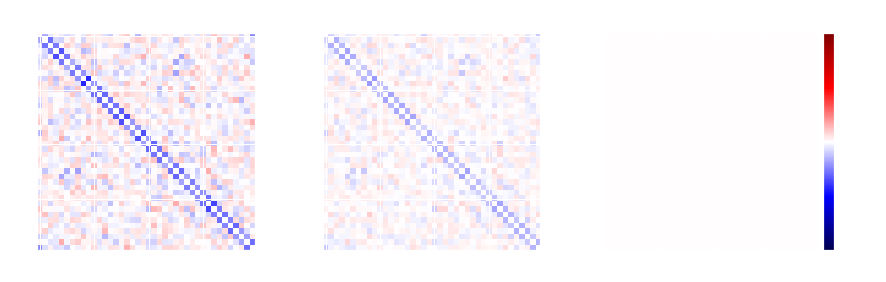

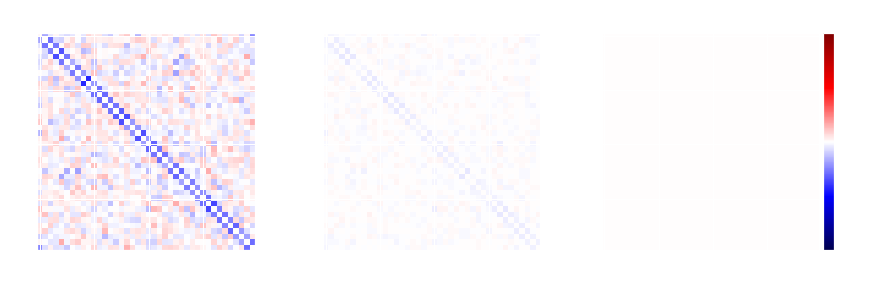

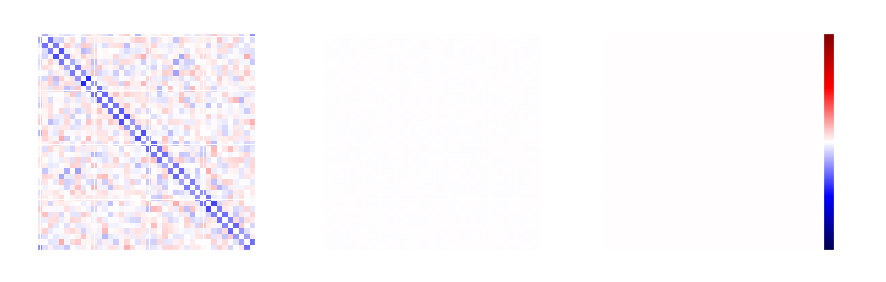

In [13]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []
train_mse_leastsq = []
test_mse_leastsq = []

train_errors_ridge = []
test_errors_ridge = []
train_mse_ridge = []
test_mse_ridge = []

train_errors_lasso = []
test_errors_lasso = []
train_mse_lasso = []
test_mse_lasso = []

# set refularisations trength values
lmbdas = np.logspace(-4, 5, 10)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for lmbda in lmbdas:
    
    ### ordinary least squares
    leastsq.fit(X_train, Y_train) # fit model 
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))
    train_mse_leastsq.append(mean_squared_error(Y_train, leastsq.predict(X_train)))
    test_mse_leastsq.append(mean_squared_error(Y_test, leastsq.predict(X_test)))
    
    ### apply Ridge regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model 
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))
    train_mse_ridge.append(mean_squared_error(Y_train, ridge.predict(X_train)))
    test_mse_ridge.append(mean_squared_error(Y_test, ridge.predict(X_test)))
    
    ### apply Ridge regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))
    train_mse_lasso.append(mean_squared_error(Y_train, lasso.predict(X_train)))
    test_mse_lasso.append(mean_squared_error(Y_test, lasso.predict(X_test)))

    ### plot Ising interaction J
    J_leastsq=np.array(leastsq.coef_).reshape((L,L))
    J_ridge=np.array(ridge.coef_).reshape((L,L))
    J_lasso=np.array(lasso.coef_).reshape((L,L))

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,**cmap_args)
    axarr[0].set_title('$\\mathrm{OLS}$',fontsize=16)
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,**cmap_args)
    axarr[1].set_title('$\\mathrm{Ridge},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso,**cmap_args)
    axarr[2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[2].tick_params(labelsize=16)
    
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im, cax=cax)
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

The OLS estimation seems to have largest values along the nearest diagnaol points to the diagonal, which represents the neigboiring spins. It is good that the OLS estimator gives largst coefficients along the these neigbouring diagonals, since the data was created by only neighbouring spins. <br>

The weights equal around -0.5 for Ridge and Lasso. This reflects the fact that each weight takes in two symmetric parts, e.g. $J_{j, j-1}$ and $J_{j, j+1}$ and the weights are distributed equally between these terms. Hence we have -1 on the digiagonal, or more precisely, on the nearest neigbour diagonals to the main diagonal. <mark> Imrpove! See Methta p.25. <br>
    
Lasso is the model that gives the best fit, since it, for a sufficiently large $\lambda$, is able to remove the insignifican parameters.

In [30]:
print(len(coefs_leastsq))
print(coefs_leastsq[0].shape)
print(coefs_leastsq[0])
print(np.mean(coefs_leastsq[0]))

10
(1600,)
[ 0.01719953 -0.16931932 -0.04915816 ...  0.04675437 -0.28581991
  0.        ]
-0.008035024305465955


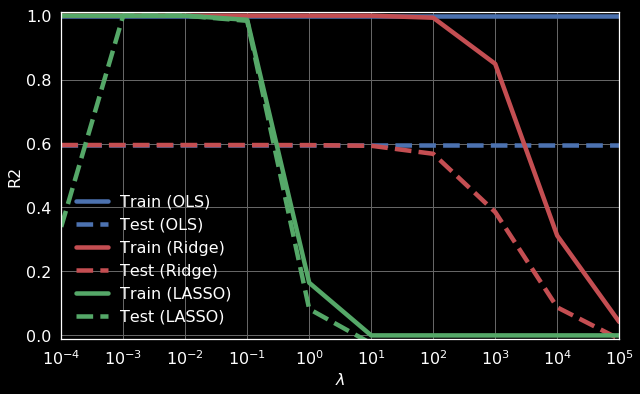

In [31]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,'r',label='Train (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, test_errors_ridge,'--r',label='Test (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.01, 1.01])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('R2',fontsize=16)
plt.tick_params(labelsize=16)
#plt.palette="pastel"
plt.show()

__Figure x:__ R2 scores. Test and training. All models. Regression. 1D. <br>
_There is a maximum $\lambda$ for both Ridge and Lasso. At some $lambda$ both the Ridge and the Lasso model starts doing worse._ <br>

The optimal $\lambda$ is around $10^{-2}$ for Lasso and $10$ for Ridge. The optima are found where the test performance peaks. <br>

Lets take a look at the MSEs.

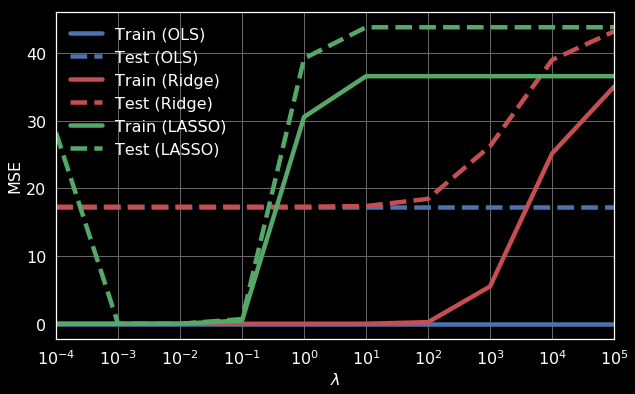

In [32]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_mse_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_mse_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_mse_ridge,'r',label='Train (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, test_mse_ridge,'--r',label='Test (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, train_mse_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_mse_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='upper left',fontsize=16)
#plt.ylim([-0.01, 1.01])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.tick_params(labelsize=16)
#plt.palette="pastel"
plt.show()

__Figure X:__ MSE. Test and training. All models. Regression. 1D. <br>
_The story is the same as for the R2-score: There are critical $\lambda$'s for which the test MSE of Ridge and Lasso start to increase. The critical $\lambda$'s are the same as for the R2-score._

In [51]:
from collections import OrderedDict
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

def bootstrap(xData, yData,  R, lmbda):
    n = xData.shape[0] 
    inds = np.arange(n); 

    mseMatrixUnknownF =  OrderedDict()
    sdMatrixUnknownF =  OrderedDict()
    bias2MatrixUnknownF =  OrderedDict()
    totalMatrixUnknownF =  OrderedDict()
    residualDictUnknownF = OrderedDict()
    
    models = ['ridge', 'lasso']
    
    for i in models:
        mseMatrixUnknownF[i] = np.zeros(n)
        sdMatrixUnknownF[i] = np.zeros(n)
        bias2MatrixUnknownF[i] = np.zeros(n)
        totalMatrixUnknownF[i] = np.zeros(n)
        residualDictUnknownF[i] = OrderedDict()
        for j in range(n):
            residualDictUnknownF[i][j] = []    
                                                                                                                                        
    for i in range(R):
        idxTrain = np.random.randint(0,n,n)
        idxValid = np.setdiff1d(np.union1d(inds, idxTrain ), np.intersect1d(inds, idxTrain))
        
        x_train = xData[idxTrain]
        y_train = yData[idxTrain]
        x_valid = xData[idxValid]
        y_valid = yData[idxValid]
        
        ridge.set_params(alpha=lmbda) # set regularisation parameter
        ridge.fit(x_train, y_train) # fit model
        yPredictRidge = ridge.predict(x_valid)
        
         
        lasso.set_params(alpha=lmbda) # set regularisation parameter
        lasso.fit(x_train, y_train) # fit model
        yPredictLasso = lasso.predict(x_valid)
        
        for i in range(len(idxValid)):
            residualDictUnknownF[models[0]][i].append(y_valid[i] -yPredictRidge[i])
            residualDictUnknownF[models[1]][i].append(y_valid[i] -yPredictLasso[i])
            
    mseUnknownF = OrderedDict()
    sdUnknownF = OrderedDict()
    bias2UnknownF = OrderedDict()
    totalUnknownF = OrderedDict()
        
    for model in models:
        for i in range(n):
            mseMatrixUnknownF[model][i] = np.mean([(residualDictUnknownF[model][i][j])**2 for j in range(len(residualDictUnknownF[model][i]))])#np.mean( (residualDictUnknownF[key])**2 )
            sdMatrixUnknownF[model][i] = np.var( residualDictUnknownF[model][i] )
            bias2MatrixUnknownF[model][i] = ( np.mean(residualDictUnknownF[model][i]) )**2
            totalMatrixUnknownF[model][i] = sdMatrixUnknownF[model][i] + \
    bias2MatrixUnknownF[model][i]
        mseUnknownF[model] = np.nanmean(mseMatrixUnknownF[model])
        sdUnknownF[model] = np.nanmean(sdMatrixUnknownF[model])
        bias2UnknownF[model] = np.nanmean(bias2MatrixUnknownF[model])
        totalUnknownF[model] = np.nanmean(totalMatrixUnknownF[model])
            
    return mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF

leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()
lmbdas = np.logspace(-4, 5, 10)
R = 50
xData = X_train
yData = Y_train
mses, sds, biases, totals = [], [], [], []
for lmbda in lmbdas:
    mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF = bootstrap(xData, yData,  R, lmbda)   
    mses.append(mseUnknownF)
    sds.append(sdUnknownF)
    biases.append(bias2UnknownF)
    totals.append(totalUnknownF)
#print(mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF)


In [52]:
msePlot = OrderedDict()
varPlot = OrderedDict()
biasPlot = OrderedDict()
totalPlot = OrderedDict()

models = ['ridge', 'lasso']
for model in models:
    msePlot[model] = []
    varPlot[model] = []
    biasPlot[model] = []
    totalPlot[model] = []


for model in models:
    for i in range(len(mses)):
        msePlot[model].append(mses[i][model])
        varPlot[model].append(sds[i][model])
        biasPlot[model].append(biases[i][model])
        totalPlot[model].append(totals[i][model])

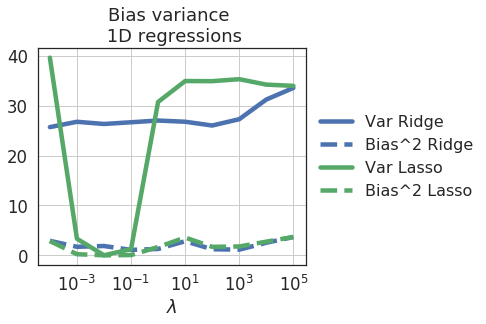

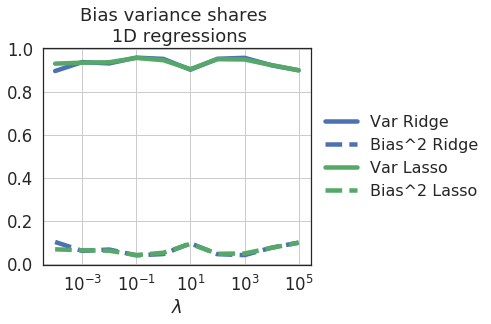

In [57]:
#print(mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF)
fig, ax = plt.subplots()
ax.semilogx(lmbdas, varPlot[models[0]], 'b',label='Var Ridge')
ax.semilogx(lmbdas, biasPlot[models[0]], '--b',label='Bias^2 Ridge')
ax.semilogx(lmbdas, varPlot[models[1]], 'g',label='Var Lasso')
ax.semilogx(lmbdas, biasPlot[models[1]], '--g',label='Bias^2 Lasso')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Bias variance \n 1D regressions')
#fig.legend(loc='right',fontsize=16)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = 16)
plt.show()

fig, ax = plt.subplots()
ax.semilogx(lmbdas, np.array(varPlot[models[0]])/np.array(msePlot[models[0]]), 'b',label='Var Ridge')
ax.semilogx(lmbdas, np.array(biasPlot[models[0]])/np.array(msePlot[models[0]]), '--b',label='Bias^2 Ridge')
ax.semilogx(lmbdas, np.array(varPlot[models[1]])/np.array(msePlot[models[1]]), 'g',label='Var Lasso')
ax.semilogx(lmbdas, np.array(biasPlot[models[1]])/np.array(msePlot[models[1]]), '--g',label='Bias^2 Lasso')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Bias variance shares \n 1D regressions')
#fig.legend(loc='right',fontsize=16)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = 16)
plt.show()

__Figure :__ Bias-variance decomposition. Ridge and Lasso. 1D regression. <br>
_It is increased variance that drives the rise of MSE._ <br>

__Figure :__ Bias-variance decopmososion. Shares of MSE. Ridge and Lasso. 1D regression. <br>
_The shares varies little with $\lambda$. The variance makes up almost 90 per cent of the MSE for both models.

When interpreting the above figure, we must keep in min that the smallest $\lambda$'s are overfitting the models. For Lasso we see that the variance comes down as $\lambda$ is increased from the lowest level. This implies that there was overfitting for the lowst $\lambda$'s. The bias for Lasso is farly constant, reflecting that the average error does not vary much with $\lambda$. When restricting the parameters a lot, the Lasso model again becomes sensitive to the training set used. At $\lambda=10^{-1}$ there is a jump in the variance for Lasso. <br>

For Ridge everything is pretty constant up to $\lambda=10^3$. At $\lambda = 10^{3}$ the variance of Ridge starts to increase, reflecting that Ridge model becomes sensitive to the training data. A small change in training data gives very different models. We had expected also the Ridge model to have a higher variance for the lowest $\lambda$, as Lasso did, since we are overfitting at low levels of $\lambda$. Perhaps even smaller levels of $\lambda$ would be necessary for Ridge to have a higher starting variance.

## Importing from data link. 2D.

In [20]:
import pickle
def read_t(t,root="./"):
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    return np.unpackbits(data).astype(int).reshape(-1,1600)

root = '/home/k/doc/subj/att/fys-stk4155/m2/IsingData/'

from collections import OrderedDict
data = OrderedDict()

temperaturs = [0.75, 2.3, 4.0]
for t in temperaturs:
    data[t] = read_t(t=0.75, root=root)

In [22]:
print(data)
print(data[0.75].shape)

OrderedDict([(0.75, array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])), (2.3, array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])), (4.0, array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]]))])
(10000, 1600)


In [25]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

def read_t(t=0.25,root="./"):
    if t > 0.:
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    else:
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=All.pkl','rb'))
    return np.unpackbits(data).astype(int).reshape(-1,1600)

stack = []
for i,t in enumerate(np.arange(0.25,4.01,0.25)):
    y = np.ones(10000,dtype=int)
    if t > 2.25:
        y*=0
    stack.append(y)

pickle.dump(np.vstack(y),open('labels_all.pkl','wb'))

#X = read_t(-1)
''' for i in range(16):
    print(np.arange(0.25,4.01,0.25)[i])
    x = X[i*10000].reshape(40,40)
    plt.imshow(x)
    plt.show() '''


''' stack = []
for t in np.arange(0.25,4.01,0.25):
    stack.append(read_t(t))

X = np.vstack(stack)
pickle.dump(np.packbits(X), open('Ising2DFM_reSample_L40_T=All.pkl','wb')) '''

" stack = []\nfor t in np.arange(0.25,4.01,0.25):\n    stack.append(read_t(t))\n\nX = np.vstack(stack)\npickle.dump(np.packbits(X), open('Ising2DFM_reSample_L40_T=All.pkl','wb')) "

In [26]:
y

array([0, 0, 0, ..., 0, 0, 0])